__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пт 27 янв 2023 17:08:13 MSK


In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [4]:
# !ls -1 data

## считываем данные

In [5]:
data_file = 'data/data_land.pkl'

In [6]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

17940


,title,adr,latitude,longitude,priceM,ts
17306,Участок 10 сот. (ИЖС),"Севастополь,",44.556972,33.526402,1.60,2023-01-27 16:42:18.173
3551,Участок 12 сот. (ИЖС),"Севастополь,садоводческое товарищество Берег, 248",44.503869,33.490793,6.09,2022-09-15 10:31:26.039
10990,Участок 30 сот. (ИЖС),"Севастополь,ТСН Сапун-Гора, ул. Андрея Кондрашина",44.543419,33.566072,54.00,2022-10-14 15:54:34.254


In [7]:
display(len(df))
df = df[ ~df['adr_orig'].isna() ].reset_index(drop=True)
display(len(df))

17940

17026

In [8]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['adr_orig'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

In [9]:
# берём объявления с геометкой
print(len(df))
df = df[ 
    ~( df['latitude'].isnull()| df['longitude'].isnull() ) 
].reset_index(drop=True)
print(len(df))

17026
17008


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17008 entries, 0 to 17007
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               17008 non-null  object        
 1   price               17008 non-null  int64         
 2   obj_name            17008 non-null  object        
 3   adr_orig            17008 non-null  object        
 4   description         17008 non-null  object        
 5   avito_page          17008 non-null  int64         
 6   ts                  17008 non-null  datetime64[ns]
 7   place               17008 non-null  object        
 8   area                17008 non-null  float64       
 9   is_IJS              17008 non-null  bool          
 10  priceM              17008 non-null  float64       
 11  priceMU             17008 non-null  float64       
 12  area_size_category  16998 non-null  category      
 13  url                 17008 non-null  object    

In [11]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
14590,Участок 6 сот. (ИЖС),"Севастополь,с. Широкое, Гвоздичный пер.",44.48,33.77,3.10,2022-11-15 13:16:46.237
5865,"Участок 9,8 сот. (ИЖС)","Севастополь,садоводческое товарищество Фрегат, 46",44.54,33.49,2.85,2022-09-19 12:39:53.571
6434,Участок 8 сот. (ИЖС),"Севастополь,с. Угловое, ул. Гунько, 86",44.83,33.58,3.90,2022-09-19 12:39:53.571


In [12]:
# # берём объявления с геометкой
# print(len(df))
# df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
# print(len(df))

---

In [13]:
# df[['longitude','latitude']].describe([.01,.1,.5,.75,.95,.99]).T

# df[ df['longitude']<31. ]

---

### ограничиваем тип объекта 

In [14]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [15]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
5962,Участок 4 сот. (ИЖС),"Севастополь,4-я Комендорская ул., 6",44.57,33.56,3.00
9587,Участок 4 сот. (ИЖС),"Севастополь,СОТ Южный",44.74,33.56,1.80
14763,Участок 4 сот. (ИЖС),"Севастополь,с. Песчаное",44.84,33.61,3.90


In [16]:
del df

In [17]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика

### количество предложений

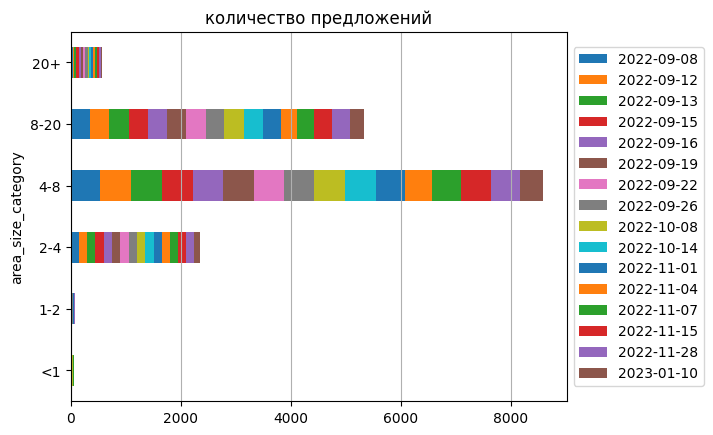

In [18]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

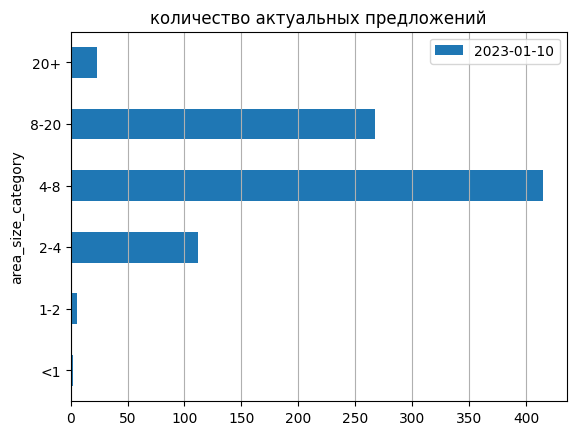

In [19]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений',)#  stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [20]:
stat = gdf.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

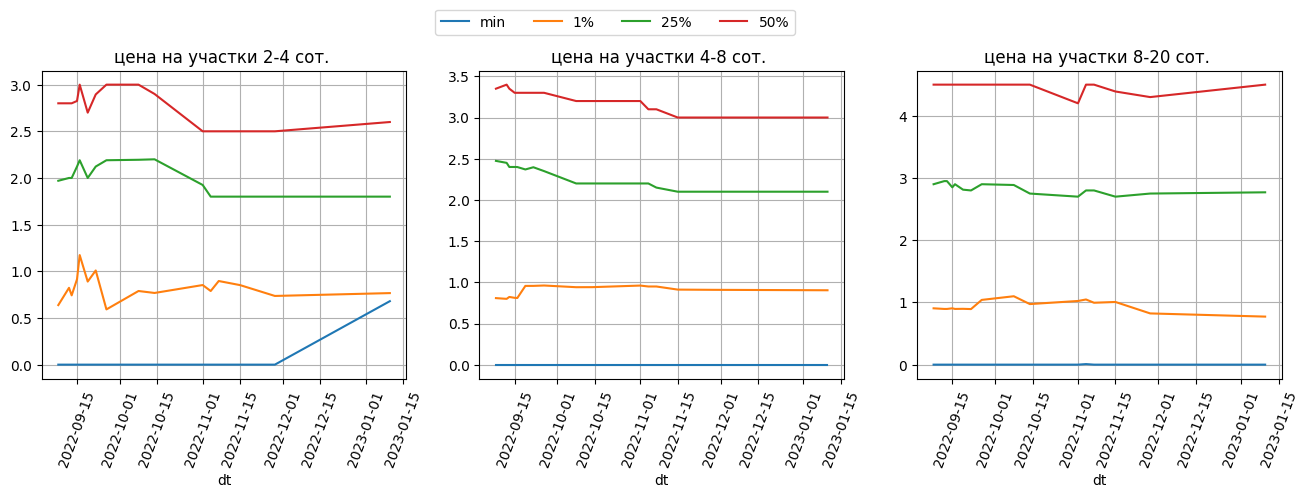

In [21]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i], legend=False,rot=70)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [22]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

In [23]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [24]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
32,862d28977ffffff,"POLYGON ((33.42254 44.59175, 33.40116 44.56227, 33.42811 44.53349, 33.47643 44.53419, 33.49782 44.56366, 33.47089 44.59244, 33.42254 44.59175))"
5,862d28947ffffff,"POLYGON ((33.49229 44.62190, 33.47089 44.59244, 33.49782 44.56366, 33.54614 44.56432, 33.56756 44.59377, 33.54065 44.62256, 33.49229 44.62190))"


In [25]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [26]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [27]:
frames.explore('area_name')

In [28]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

17008
553


In [29]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[ gdf_['dt']==gdf_['dt'].max() ][cols].explore( 'area_size_category',legend=True)

In [30]:
locations = ' | '.join(area_name)
locations

'Севастополь, кр.горка'

### количество предложений

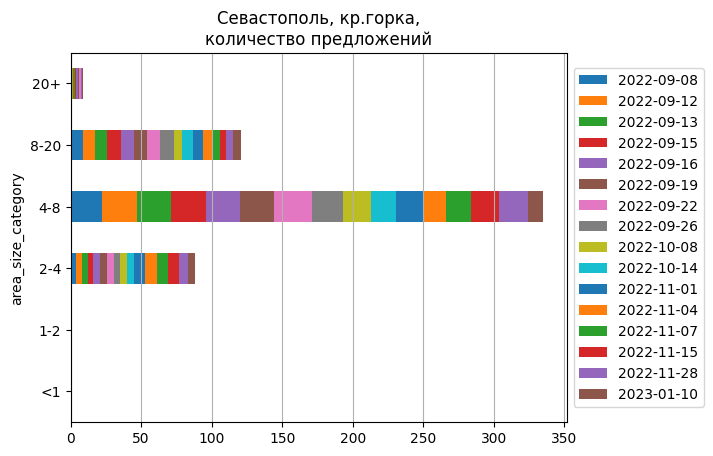

In [31]:
fig = ( # количество предложений
        gdf_
        .groupby(['dt','area_size_category'])
        .size().reset_index()
        .pivot(index='area_size_category', columns='dt', values=0)
        .plot
        .barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
    )
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')


In [32]:
# ( 
#     gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
#     .groupby(['dt','area_size_category'])
#     .size().reset_index()
#     .pivot(index='area_size_category', columns='dt', values=0)
# )#.info()

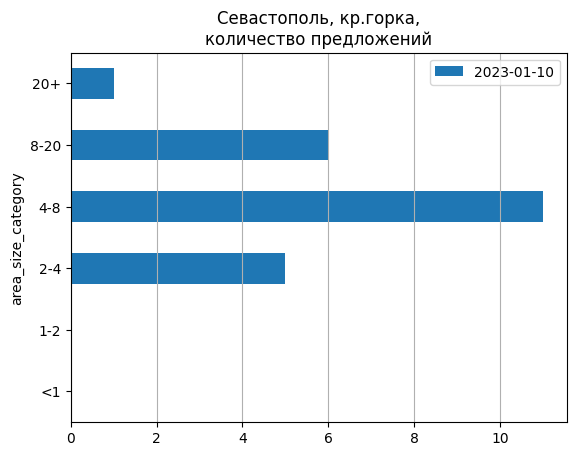

In [33]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot.barh( legend=False,title=f'{locations},\nколичество предложений')#, stacked=True )
)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [34]:
stat = gdf_.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

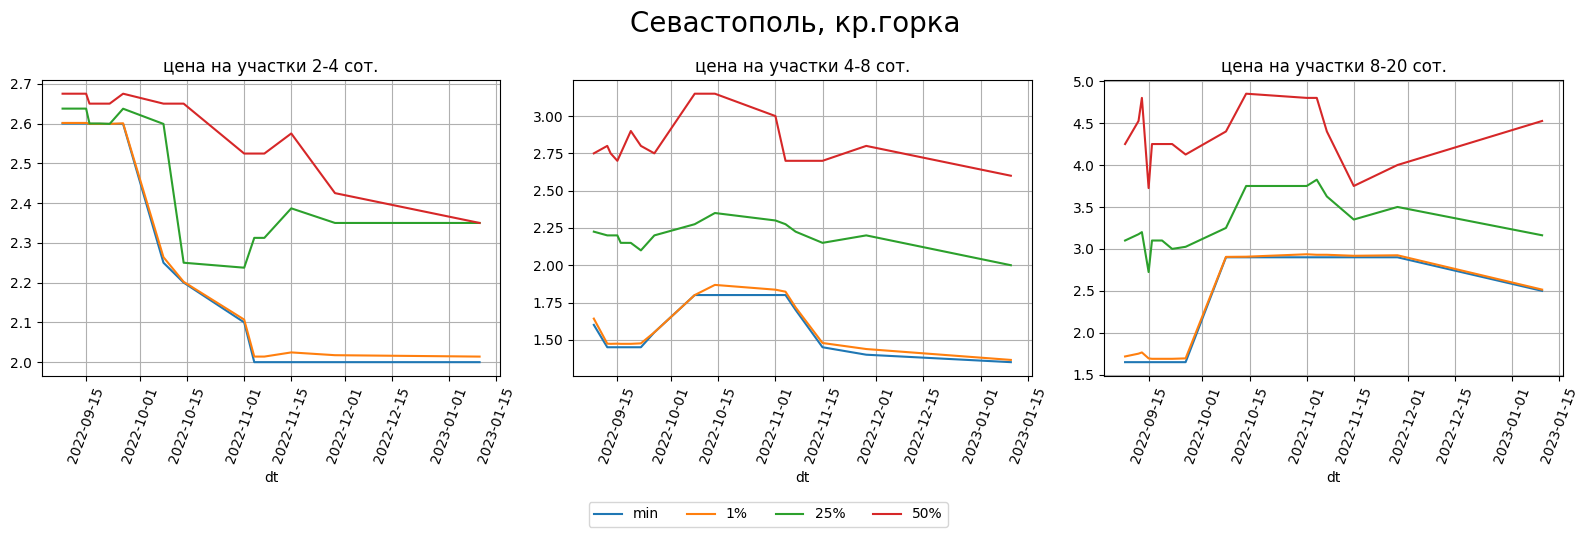

In [35]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)

fig, ax = plt.subplots(1,len(sizes),figsize=(16,5), sharey=False) #,title=locations)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(
        grid=True, 
        title=f'цена на участки {s} сот.',
        ax=ax[i], 
        legend=False,
        rot=70,
    )
fig.suptitle(locations, fontsize=20)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()
# plt.show()

### гексагональная сетка и медиана актуальной цены

In [36]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
28,892d2895c87ffff,"POLYGON ((33.55291 44.57632, 33.55259 44.57453, 33.55467 44.57337, 33.55708 44.57399, 33.55740 44.57578, 33.55532 44.57695, 33.55291 44.57632))"
24,892d28943c3ffff,"POLYGON ((33.53864 44.58624, 33.53832 44.58445, 33.54040 44.58329, 33.54281 44.58392, 33.54314 44.58571, 33.54105 44.58687, 33.53864 44.58624))"


In [37]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt'] == gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)